# Customer Churn Prediction at Beta Bank

Customers at Beta Bank are gradually leaving every month. Bankers have discovered that it is cheaper to retain existing customers than to attract new ones.

We need to predict if a customer will leave the bank soon. You have data on past customer behavior and contract terminations with the bank.

Create a model with the highest possible F1 score. To pass the review, you need an F1 score of at least 0.59. Verify the F1 score on the test set.

Additionally, you should measure the AUC-ROC metric and compare it with the F1 score.

# Data Description

Features:

- `RowNumber` - index of data record
- `CustomerId` - unique customer identifier
- `Surname` - last name
- `CreditScore` - credit score value
- `Geography` - country of residence
- `Gender` - gender
- `Age` - age
- `Tenure` - period for which a customer's fixed deposit has matured (in years)
- `Balance` - account balance
- `NumOfProducts` - number of banking products used by the customer
- `HasCrCard` - whether the customer has a credit card (1 – yes; 0 – no)
- `IsActiveMember` - customer activity status (1 – active; 0 – inactive)
- `EstimatedSalary` - estimated salary


# Initialization

In [174]:
# Load libraries

# Data manipulation
import pandas as pd
import itertools
import numpy as np
from scipy.stats import chi2_contingency
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler

# Modeling
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.dummy import DummyClassifier
from sklearn.model_selection import GridSearchCV

# Evaluation
from sklearn.metrics import precision_score, recall_score, f1_score, roc_auc_score

# Visualization
import matplotlib.pyplot as plt
import seaborn as sns

# Load data

In [175]:
# Load the data into DataFrames
df = pd.read_csv('../datasets/Churn.csv')

In [176]:
# Print the general/summary information about the DataFrames
df.info()

# Print a random sample of 5 rows from the DataFrame
df.sample(5)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10000 entries, 0 to 9999
Data columns (total 14 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   RowNumber        10000 non-null  int64  
 1   CustomerId       10000 non-null  int64  
 2   Surname          10000 non-null  object 
 3   CreditScore      10000 non-null  int64  
 4   Geography        10000 non-null  object 
 5   Gender           10000 non-null  object 
 6   Age              10000 non-null  int64  
 7   Tenure           9091 non-null   float64
 8   Balance          10000 non-null  float64
 9   NumOfProducts    10000 non-null  int64  
 10  HasCrCard        10000 non-null  int64  
 11  IsActiveMember   10000 non-null  int64  
 12  EstimatedSalary  10000 non-null  float64
 13  Exited           10000 non-null  int64  
dtypes: float64(3), int64(8), object(3)
memory usage: 1.1+ MB


,RowNumber,CustomerId,Surname,CreditScore,Geography,Gender,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary,Exited
9466,9467,15592716,Clarke,559,France,Male,52,NaN,0.0,1,1,0,129013.59,1
1432,1433,15687959,Landman,573,Spain,Female,44,4.0,0.0,1,1,1,94862.93,0
3896,3897,15767894,Ch'ien,741,France,Female,21,9.0,0.0,2,0,1,139259.54,0
4195,4196,15747168,Sanders,626,Germany,Female,47,2.0,103108.8,1,0,1,166475.44,1
5976,5977,15807163,Ku,537,France,Female,38,10.0,0.0,1,0,0,52337.97,1


## Observations
- The `Tenure` column has around 10% of missing values.
- The columns `RowNumber`, `CustomerId`, and `Surname` do not contain relevant information for the model predictions.

# Prepare data

## Remove unnecessary columns

In [177]:
# Remove the columns that will not be used in the analysis
df = df.drop(['RowNumber', 'CustomerId', 'Surname'], axis=1)

## Impute data

<Axes: >

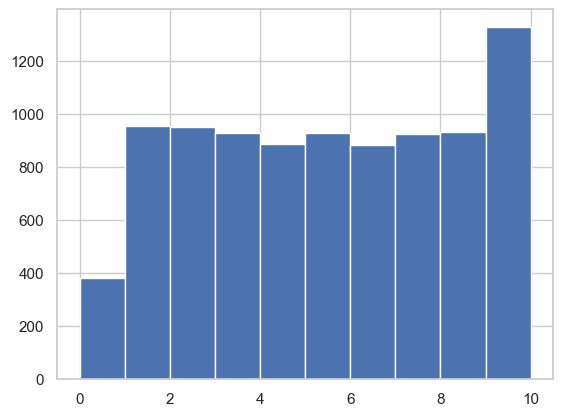

In [178]:
# Check if the 'Tenure' column has a normal distribution
df['Tenure'].hist(bins=10)

## Observations
- The `Tenure` column does not show a normal distribution, so it is decided to use the median to impute the missing data.

In [179]:
# Input the missing values in the Tenure column with the median
df['Tenure'] = df['Tenure'].fillna(df['Tenure'].median())

# Print the general/summary information about the DataFrame
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10000 entries, 0 to 9999
Data columns (total 11 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   CreditScore      10000 non-null  int64  
 1   Geography        10000 non-null  object 
 2   Gender           10000 non-null  object 
 3   Age              10000 non-null  int64  
 4   Tenure           10000 non-null  float64
 5   Balance          10000 non-null  float64
 6   NumOfProducts    10000 non-null  int64  
 7   HasCrCard        10000 non-null  int64  
 8   IsActiveMember   10000 non-null  int64  
 9   EstimatedSalary  10000 non-null  float64
 10  Exited           10000 non-null  int64  
dtypes: float64(3), int64(6), object(2)
memory usage: 859.5+ KB


## Transform data

In [180]:
# Create a list of columns that are of type object
object_columns = list(df.select_dtypes(include=['object']).columns)

# Encode only the categorical variables (object type columns) with one-hot encoding
df = pd.get_dummies(df, columns=object_columns, drop_first=True)

# Print the general/summary information about the DataFrames
df.info()

# Print the first 5 rows of the DataFrame
df.head()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10000 entries, 0 to 9999
Data columns (total 12 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   CreditScore        10000 non-null  int64  
 1   Age                10000 non-null  int64  
 2   Tenure             10000 non-null  float64
 3   Balance            10000 non-null  float64
 4   NumOfProducts      10000 non-null  int64  
 5   HasCrCard          10000 non-null  int64  
 6   IsActiveMember     10000 non-null  int64  
 7   EstimatedSalary    10000 non-null  float64
 8   Exited             10000 non-null  int64  
 9   Geography_Germany  10000 non-null  uint8  
 10  Geography_Spain    10000 non-null  uint8  
 11  Gender_Male        10000 non-null  uint8  
dtypes: float64(3), int64(6), uint8(3)
memory usage: 732.6 KB


,CreditScore,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary,Exited,Geography_Germany,Geography_Spain,Gender_Male
0,619,42,2.0,0.00,1,1,1,101348.88,1,0,0,0
1,608,41,1.0,83807.86,1,0,1,112542.58,0,0,1,0
2,502,42,8.0,159660.80,3,1,0,113931.57,1,0,0,0
3,699,39,1.0,0.00,2,0,0,93826.63,0,0,0,0
4,850,43,2.0,125510.82,1,1,1,79084.10,0,0,1,0


In [181]:
# Change the data type of the numeric columns to uint8
df['HasCrCard'] = df['HasCrCard'].astype('uint8')
df['IsActiveMember'] = df['IsActiveMember'].astype('uint8')
df['Exited'] = df['Exited'].astype('uint8')

In [182]:
# Create a list of columns that are of numeric type
numeric_columns = list(df.select_dtypes(include=['float64', 'int64']).columns)

# Normalize the numerical variables
scaler = StandardScaler()
df[numeric_columns] = scaler.fit_transform(df[numeric_columns])

# Print the general/summary information about the DataFrames
df.info()

# Print a random sample of 5 rows from the DataFrame
df.sample(5)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10000 entries, 0 to 9999
Data columns (total 12 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   CreditScore        10000 non-null  float64
 1   Age                10000 non-null  float64
 2   Tenure             10000 non-null  float64
 3   Balance            10000 non-null  float64
 4   NumOfProducts      10000 non-null  float64
 5   HasCrCard          10000 non-null  uint8  
 6   IsActiveMember     10000 non-null  uint8  
 7   EstimatedSalary    10000 non-null  float64
 8   Exited             10000 non-null  uint8  
 9   Geography_Germany  10000 non-null  uint8  
 10  Geography_Spain    10000 non-null  uint8  
 11  Gender_Male        10000 non-null  uint8  
dtypes: float64(6), uint8(6)
memory usage: 527.5 KB


,CreditScore,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary,Exited,Geography_Germany,Geography_Spain,Gender_Male
4673,-0.067552,-0.564665,-1.086246,-1.225848,-0.911583,1,0,-0.063812,0,0,0,1
4101,0.232504,1.723821,-0.361575,-1.225848,0.807737,1,1,-0.876513,0,0,1,0
8619,1.029206,-0.278604,0.363096,-1.225848,0.807737,1,1,-0.700322,0,0,1,0
4194,-0.812520,1.437761,1.450103,0.334913,-0.911583,1,1,1.663809,0,1,0,0
6785,-0.305528,0.198164,0.000761,0.451095,-0.911583,1,1,-0.078929,0,0,1,1


# EDA

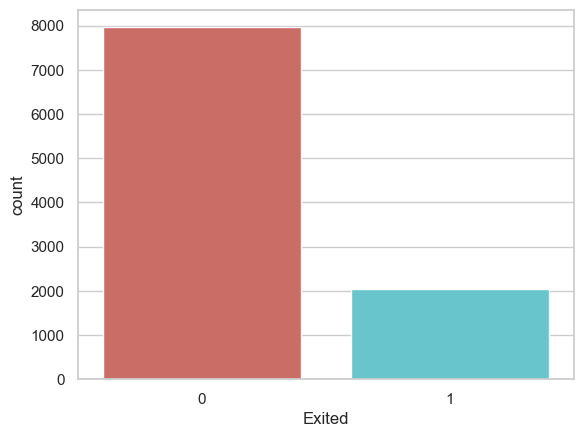

In [183]:
# Create a graph to visualize the distribution of the target variable
sns.countplot(x='Exited', data=df, palette='hls')
plt.show()

## Observations
- `Exited`, which is the target column, has a clear class imbalance (around 80% is concentrated in one of the two possible values).

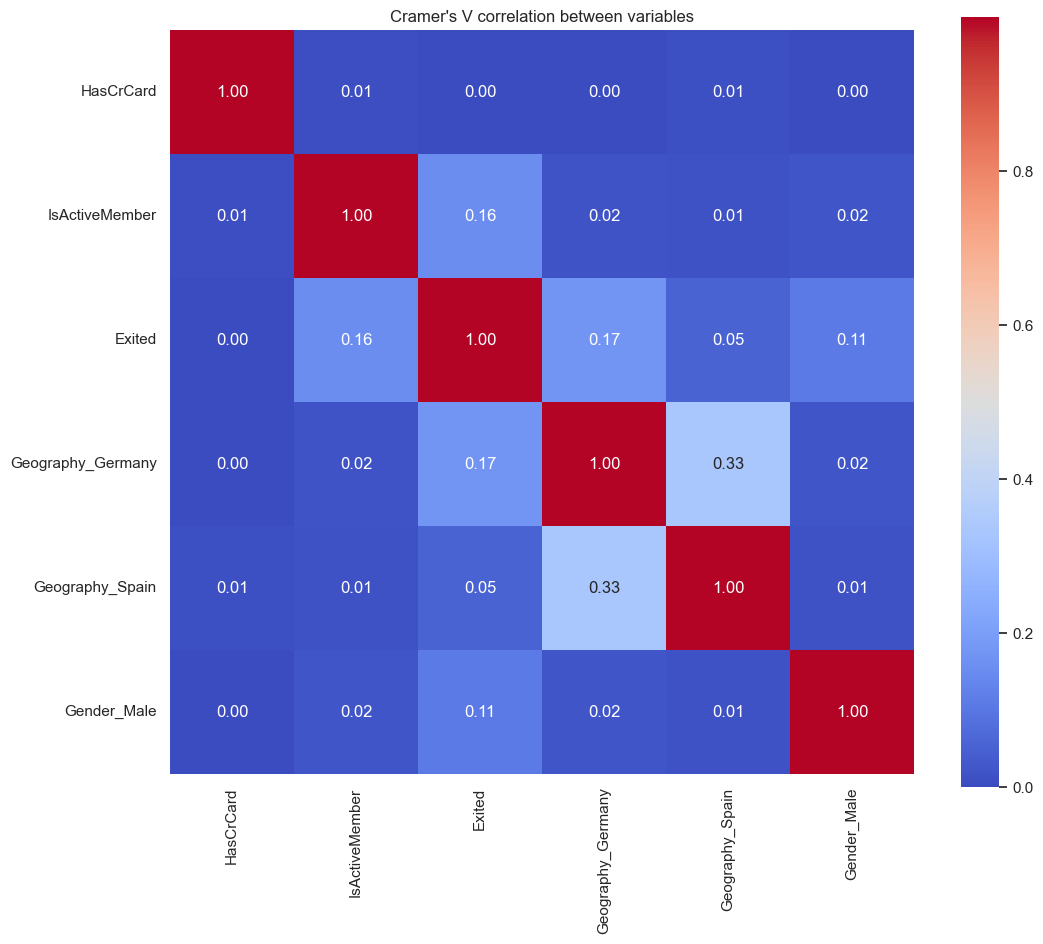

In [184]:
# Create a function to calculate Cramer's V for categorical-categorical association
def cramers_v(x, y):
    confusion_matrix = pd.crosstab(x, y)
    chi2 = chi2_contingency(confusion_matrix)[0]
    n = confusion_matrix.sum().sum()
    phi2 = chi2 / n
    r, k = confusion_matrix.shape
    phi2corr = max(0, phi2 - ((k-1)*(r-1))/(n-1))
    rcorr = r - ((r-1)**2)/(n-1)
    kcorr = k - ((k-1)**2)/(n-1)
    return np.sqrt(phi2corr / min((kcorr-1), (rcorr-1)))

# Create an association matrix for all categorical variables
categorical_columns = df.select_dtypes(include=['uint8']).columns

n = len(categorical_columns)
association_matrix = np.zeros((n, n))

for i, j in itertools.product(range(n), range(n)):
    association_matrix[i, j] = cramers_v(df[categorical_columns[i]], df[categorical_columns[j]])

association_df = pd.DataFrame(association_matrix, index=categorical_columns, columns=categorical_columns)

# Create a heatmap to visualize the association matrix
plt.figure(figsize=(12, 10))
sns.heatmap(association_df, annot=True, cmap="coolwarm", cbar=True, square=True, fmt=".2f")
plt.title("Cramer's V correlation between variables")
plt.show()

In [185]:
# Print the association values for the Churn column
association_df['Exited'].sort_values(ascending=False)

Exited               0.999692
Geography_Germany    0.172921
IsActiveMember       0.155567
Gender_Male          0.105797
Geography_Spain      0.051418
HasCrCard            0.000000
Name: Exited, dtype: float64

## Observations

- The columns with correlations closest to zero for the target variable `Exited` will be removed to speed up model training stage:
    - `HasCrCard`
    - `Geography_Spain`

In [186]:
# Drop the following columns as they are not relevant to the prediction of Churn or they are highly correlated with other columns
cols = ["HasCrCard", "Geography_Spain"]
df.drop(cols, axis=1, inplace=True)

# Print the general/summary information about the DataFrames
df.info()

# Print a random sample of 5 rows from the DataFrame
df.sample(5)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10000 entries, 0 to 9999
Data columns (total 10 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   CreditScore        10000 non-null  float64
 1   Age                10000 non-null  float64
 2   Tenure             10000 non-null  float64
 3   Balance            10000 non-null  float64
 4   NumOfProducts      10000 non-null  float64
 5   IsActiveMember     10000 non-null  uint8  
 6   EstimatedSalary    10000 non-null  float64
 7   Exited             10000 non-null  uint8  
 8   Geography_Germany  10000 non-null  uint8  
 9   Gender_Male        10000 non-null  uint8  
dtypes: float64(6), uint8(4)
memory usage: 507.9 KB


,CreditScore,Age,Tenure,Balance,NumOfProducts,IsActiveMember,EstimatedSalary,Exited,Geography_Germany,Gender_Male
4330,1.349956,-1.899615,-0.723910,-1.225848,0.807737,1,0.420937,0,0,0
5294,-1.464367,-0.660018,1.450103,1.509362,-0.911583,1,-1.364063,0,1,1
9090,1.639666,0.007457,0.000761,-1.225848,-0.911583,0,-0.389244,0,0,0
852,-1.443673,0.198164,1.087768,1.240655,-0.911583,1,-1.060778,0,1,0
6216,-1.774770,0.770285,-1.448581,-1.225848,-0.911583,0,-0.083805,0,0,1


## Oversampling

In [187]:
# Set random seed for reproducibility
random_state = 12345

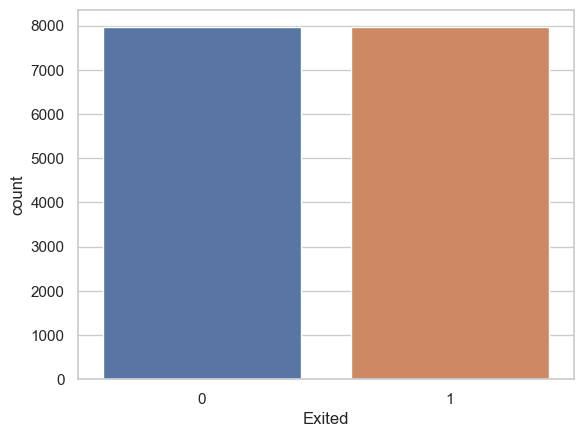

In [188]:
# Adjust the class imbalance by oversampling the minority class
df_majority = df[df['Exited'] == 0]
df_minority = df[df['Exited'] == 1]
df_minority_upsampled = df_minority.sample(df_majority.shape[0], replace=True,  random_state=random_state)
df = pd.concat([df_majority, df_minority_upsampled]).sample(frac=1, random_state=random_state).reset_index(drop=True)

# Create a graph to visualize the distribution of the target variable
sns.countplot(x='Exited', data=df)
plt.show()

In [189]:
# Print the general/summary information about the DataFrames
df.info()

# Print a random sample of 5 rows from the DataFrame
df.sample(5)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 15926 entries, 0 to 15925
Data columns (total 10 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   CreditScore        15926 non-null  float64
 1   Age                15926 non-null  float64
 2   Tenure             15926 non-null  float64
 3   Balance            15926 non-null  float64
 4   NumOfProducts      15926 non-null  float64
 5   IsActiveMember     15926 non-null  uint8  
 6   EstimatedSalary    15926 non-null  float64
 7   Exited             15926 non-null  uint8  
 8   Geography_Germany  15926 non-null  uint8  
 9   Gender_Male        15926 non-null  uint8  
dtypes: float64(6), uint8(4)
memory usage: 808.9 KB


,CreditScore,Age,Tenure,Balance,NumOfProducts,IsActiveMember,EstimatedSalary,Exited,Geography_Germany,Gender_Male
10478,1.101634,1.723821,-0.723910,0.201838,-0.911583,1,-0.815736,1,0,1
6528,-0.760786,-0.183251,-0.361575,-1.225848,-0.911583,1,-0.351412,0,0,0
11817,1.070593,0.579578,0.363096,-1.225848,-0.911583,0,-0.455741,1,0,0
11156,-2.333496,-1.613554,0.725432,1.493147,0.807737,1,0.630782,1,0,0
2585,-1.588528,-0.660018,1.087768,0.561772,4.246377,1,-1.575309,1,1,0


# Model construction

## Data Segmentation

In [190]:
# Split the DataFrame into features and target
features = df.drop(['Exited'], axis=1)
target = df['Exited']

In [191]:
# Separate the data into training, validation, and test subsets (3:1:1)
features_train, features_valid, target_train, target_valid = train_test_split(features, target, test_size=0.4, random_state=random_state)
features_valid, features_test, target_valid, target_test = train_test_split(features_valid, target_valid, test_size=0.5, random_state=random_state)

## Find the best hyperparameters

In [192]:
# Set the scoring metric to be used for choosing the best hyperparameters
scoring = 'f1'

In [193]:
# Create a function to calculate the best hyperparameters for a list of models
def find_best_params(models, train_features, train_targets, scoring):
    # Create a DataFrame to store the results
    results = pd.DataFrame(columns=['Model', 'Best Parameters', 'Best Score'])

    # Iterate through the list of models
    for model in models:
        # Print the name of the model
        print(f"Finding best parameters for {type(model['model']).__name__}...")

        # Perform a grid search of the hyperparameters
        grid = GridSearchCV(model['model'], model['param_grid'], cv=5, scoring=scoring, verbose=0, n_jobs=-1)
        grid.fit(train_features, train_targets)

        # Extract best parameters and score
        best_params = grid.best_params_
        best_score = np.abs(grid.best_score_)

        # Store the results in the DataFrame
        results = pd.concat([results, pd.DataFrame({'Model': type(model['model']).__name__, 
                                  'Best Parameters': [best_params], 
                                  'Best Score': best_score})], ignore_index=True)

        # Sort the DataFrame by best score
        results.sort_values(by='Best Score', ascending=False, inplace=True)

    # Create a bar plot to visualize the best scores
    plt.figure(figsize=(12, 10))
    sns.barplot(data=results, x='Model', y='Best Score', palette="coolwarm")
    plt.title("Grid Search Results")
    plt.xticks(rotation=45)
    plt.tight_layout()

    return results

Finding best parameters for LogisticRegression...
Finding best parameters for RandomForestClassifier...
Finding best parameters for DecisionTreeClassifier...


,Model,Best Parameters,Best Score
0,RandomForestClassifier,"{'max_depth': 14, 'n_estimators': 200}",0.902227
2,DecisionTreeClassifier,{'max_depth': 14},0.849857
1,LogisticRegression,{},0.697412


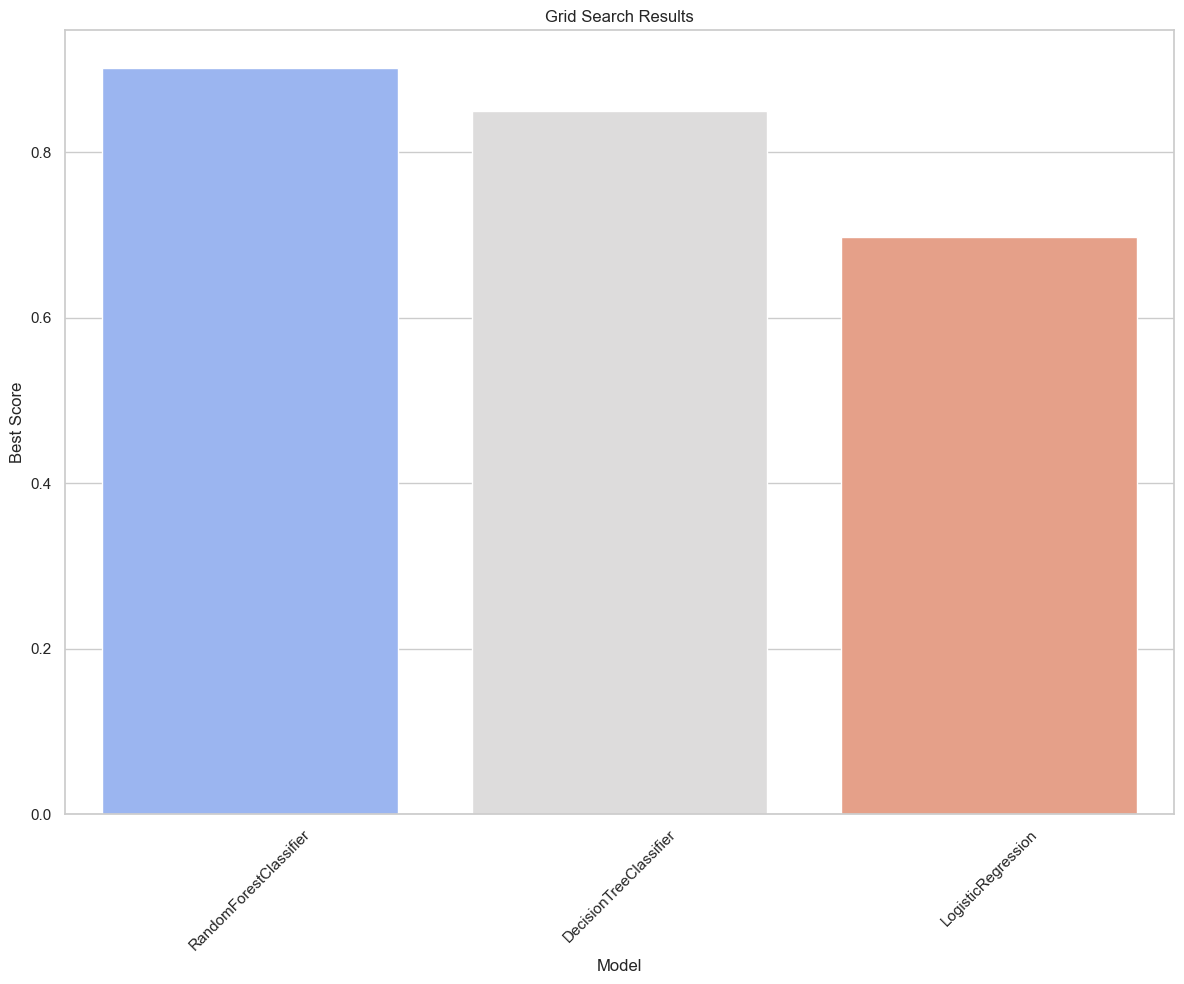

In [194]:
# Define the models and their basic hyperparameters
models = [
    {
        'model': LogisticRegression(random_state=random_state),
        'param_grid': {}
    },
    {
        'model': RandomForestClassifier(random_state=random_state),
        'param_grid': {'n_estimators': np.arange(50, 201, 50), 'max_depth': np.arange(3, 15)}
    },
    {
        'model': DecisionTreeClassifier(random_state=random_state),
        'param_grid': {'max_depth': np.arange(3, 15)}
    },
]

# Find the best hyperparameters for each model
results = find_best_params(models, features_train, target_train, scoring)

# Print the results
results

In [195]:
# Set the index of the DataFrame to the model name
results.set_index('Model', inplace=True)

# Set the hyperparameters for each model based on the results of the grid search
models = [
    LogisticRegression(random_state=random_state, **results.loc['LogisticRegression']['Best Parameters']),
    RandomForestClassifier(random_state=random_state, **results.loc['RandomForestClassifier']['Best Parameters']),
    DecisionTreeClassifier(random_state=random_state, **results.loc['DecisionTreeClassifier']['Best Parameters']),
]

## Train and evaluate models

In [196]:
# Create a function to train and evaluate multiple models on the training and validation subsets and create a graph to visualize the results
def train_and_evaluate_models(models, features_train, target_train, features_valid, target_valid):
    # Create a DataFrame to store the results
    results = pd.DataFrame(columns=['Model', 'Accuracy', 'Precision', 'Recall', 'F1', 'ROC_AUC'])
    
    # Loop through each model
    for model in models:
        # Train the model
        model.fit(features_train, target_train)
        
        # Make predictions
        predictions = model.predict(features_valid)
        
        # Evaluate the model
        accuracy = model.score(features_valid, target_valid)
        precision = precision_score(target_valid, predictions)
        recall = recall_score(target_valid, predictions)
        f1 = f1_score(target_valid, predictions)
        roc_auc = roc_auc_score(target_valid, predictions)
        
        # Append the results to the DataFrame
        results = pd.concat([results, pd.DataFrame({'Model': model.__class__.__name__, 'Accuracy': accuracy, 'Precision': precision, 'Recall': recall, 'F1': f1, 'ROC_AUC': roc_auc}, index=[0])], ignore_index=True)
    
    # Draw a heatmap to visualize the results
    plt.figure(figsize=(14,7))
    sns.set(style="whitegrid")
    sns.heatmap(results.set_index('Model'), annot=True, cmap='RdBu_r')
    plt.title('Model Comparison')
    plt.ylabel('Model')
    plt.tight_layout()
    plt.show()

    return results

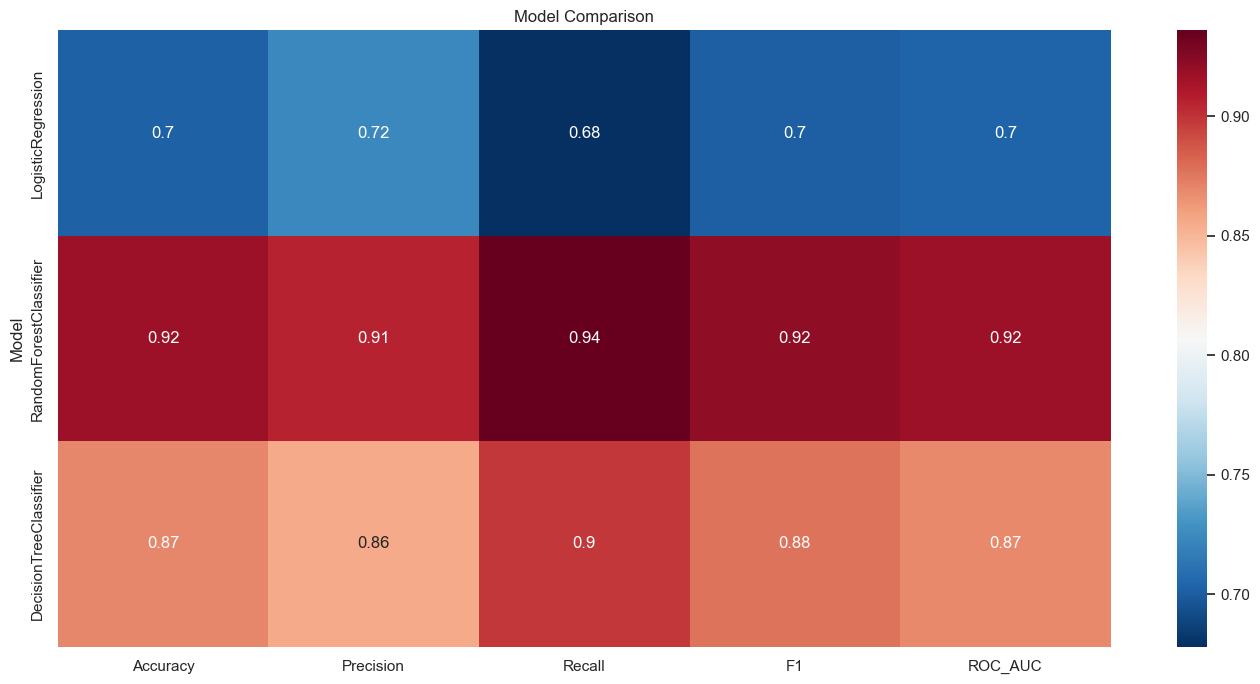

,Model,Accuracy,Precision,Recall,F1,ROC_AUC
0,LogisticRegression,0.701727,0.724070,0.678070,0.700315,0.702407
1,RandomForestClassifier,0.917425,0.906509,0.935858,0.920950,0.916896
2,DecisionTreeClassifier,0.870016,0.855730,0.898595,0.876639,0.869194


In [197]:
# Train and evaluate the models
train_results = train_and_evaluate_models(models, features_train, target_train, features_valid, target_valid)

# Print the results
train_results

## Intermediate Conclusion
- **Accuracy**: `RandomForestClassifier` has the highest accuracy, with an approximate value of 91.74%.
- **Precision**: `RandomForestClassifier` has the highest precision, with an approximate value of 90.65%.
- **Recall**: `RandomForestClassifier` has the highest recall, with an approximate value of 93.58%.
- **F1**: `RandomForestClassifier` has the highest F1 score, with a value of 92.09%.
- **ROC_AUC**: `RandomForestClassifier` has the best ROC_AUC evaluation, with an approximate value of 91.68%.

Overall, `RandomForestClassifier` would be the model with the best scores.

# Model Quality Assessment

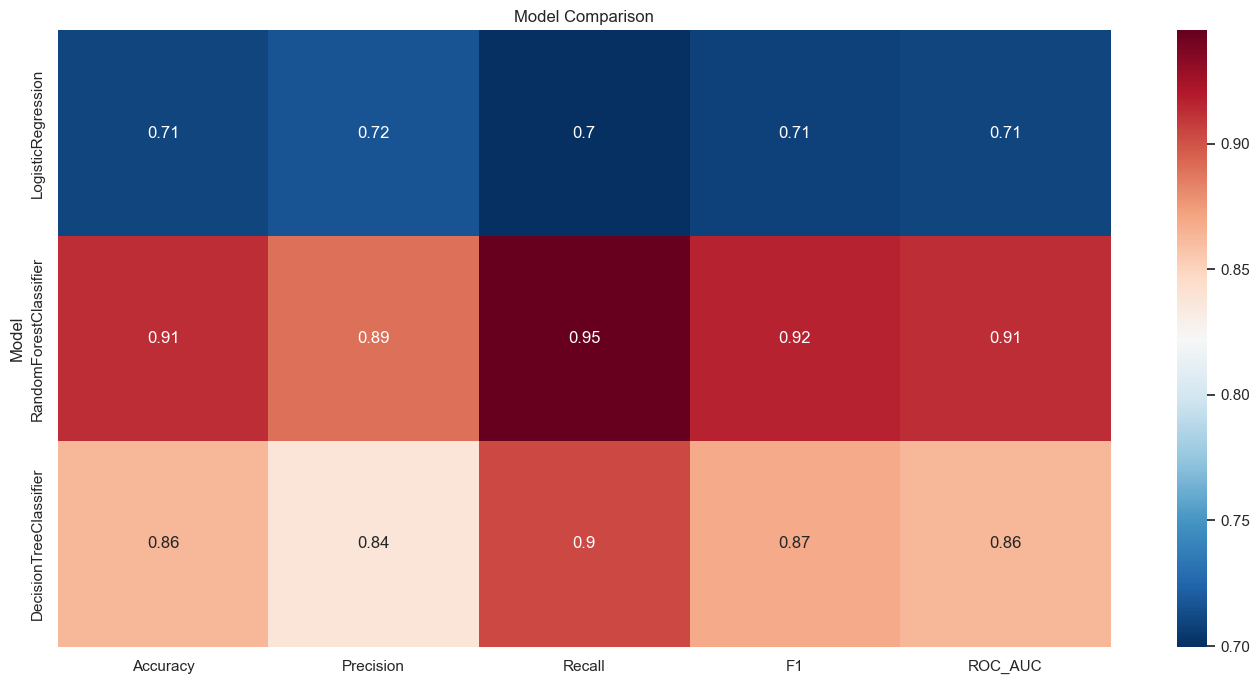

,Model,Accuracy,Precision,Recall,F1,ROC_AUC
0,LogisticRegression,0.709981,0.716752,0.699750,0.708149,0.710039
1,RandomForestClassifier,0.913371,0.889542,0.945069,0.916465,0.913191
2,DecisionTreeClassifier,0.863465,0.837869,0.903246,0.869330,0.863239


In [198]:
# Train and evaluate the models on the test set
test_results = train_and_evaluate_models(models, features_train, target_train, features_test, target_test)

# Print the results
test_results

## Intermediate Conclusion

`RandomForestClassifier` has shown the best performance on all metrics with both the validation and test sets. These results are consistent and demonstrate that the model is robust and reliable.

## Sanity Check

/opt/homebrew/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1469: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


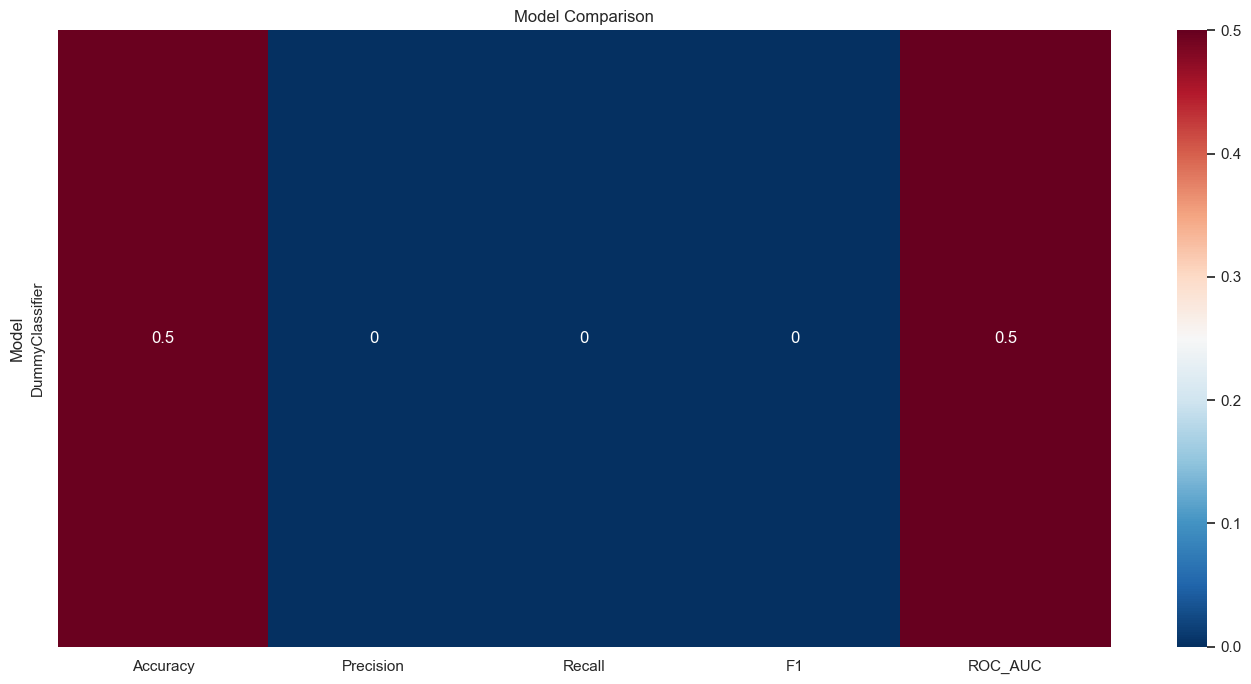

,Model,Accuracy,Precision,Recall,F1,ROC_AUC
0,DummyClassifier,0.497175,0.0,0.0,0.0,0.5


In [199]:
# Create a dummy classifier that always predicts the most frequent class
dummy = DummyClassifier(strategy='most_frequent', random_state=random_state)

# Train and evaluate the dummy classifier on the test set
sanity_check_results = train_and_evaluate_models([dummy], features_train, target_train, features_test, target_test)

# Print the results
sanity_check_results

## Intermediate Conclusion

- The `Accuracy` score of the `Dummy Classifier` is close to 50%.
- The `AUC-ROC` score of the `Dummy Classifier` is 50%.

Both previous results indicate that classes on the target variable are balanced and that it has no ability to distinguish between them, it's like guessing randomly, just what we would expect from the `DummyClassifier`. Also with this result we corroborate our chosen model works properly.

# General Conclusion

The tested classification models included `Logistic Regression`, `Decision Tree`, and `Random Forest`. To address the class imbalance in the dataset, upsampling method was implemented. The analysis revealed that:

- The `Logistic Regression` model had the lowest F1 score, although it was the fastest in terms of execution time.
- The `Decision Tree` model, despite performing better than the worst model, failed to outperform the best model.
- The `Random Forest` model, demonstrated the highest F1 score (**91.64%**), although it required the longest execution time.

These results highlight the effectiveness of `Random Forest` on this dataset and the importance of techniques like upsampling to address challenges posed by class imbalance.